# Bayesian Lasso

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
np.random.seed(42)

#### Example 1

We simulated n = 20 data set to fit models and n = 200 data set
to compare prediction errors of proposed models with eight predictors. We let
$β = (3, 1.5, 0, 0, 2, 0, 0, 0)′$ and $σ = 3$. The pairwise correlation between $x_i$ and $x_j$
was set to be $corr(i, j) = 0.5^{|i−j|}$

In [10]:
# Parameters
n_train = 200  # Number of training samples
n_test = 200  # Number of testing samples
p = 8         # Number of predictors
beta1 = np.array([3, 1.5, 0, 0, 2, 0, 0, 0])  # True regression coefficients
sigma = 3     # Standard deviation of noise
corr_decay = 0.5

# Create covariance matrix based on corr(i, j) = 0.5^|i-j|
cov_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Generate training predictors and noise
X_train = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_train)
epsilon_train = np.random.normal(loc=0, scale=1, size=n_train)

# Generate training response (y)
y_train = X_train @ beta1 + sigma * epsilon_train

# Generate testing predictors and noise
X_test = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_test)
epsilon_test = np.random.normal(loc=0, scale=1, size=n_test)

# Generate testing response (y)
y_test = X_test @ beta1 + sigma * epsilon_test

# Output data
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (200, 8) (200,)
Testing data shape: (200, 8) (200,)


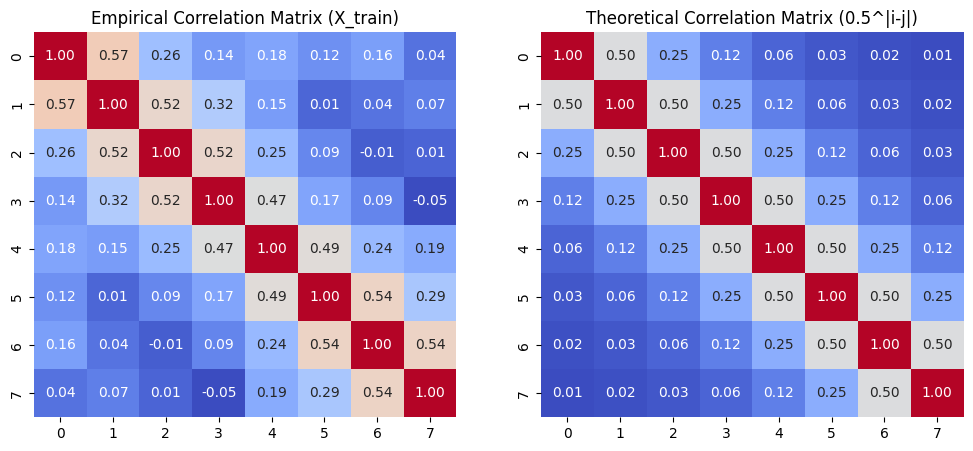

In [11]:
# Calculate empirical correlation matrix
corr_matrix = np.corrcoef(X_train, rowvar=False)

# Calculate theoretical correlation matrix
p = X_train.shape[1]
theoretical_corr_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[0], cbar=False)
axes[0].set_title("Empirical Correlation Matrix (X_train)")
sns.heatmap(theoretical_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1], cbar=False)
axes[1].set_title("Theoretical Correlation Matrix (0.5^|i-j|)")

# plt.tight_layout()
plt.show()

In [12]:
# Simple linear regression model
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(lr.intercept_)
print(lr.coef_)

-0.09691401651328957
[ 2.95720802  1.43856599  0.0314522   0.01109248  2.25497698 -0.31655006
  0.38403223 -0.27503394]


##### Frequentist Lasso

In [6]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Define parameter grid for alpha (regularization parameter)
param_grid = {'alpha': [0.01, 0.1, 0.3, 0.5, 0.8, 0.9, 1, 1.1, 2, 5, 10]}

# Perform Grid Search with Cross-Validation
grid = GridSearchCV(Lasso(fit_intercept=True), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Retrieve the best alpha and corresponding model
best_alpha = grid.best_params_['alpha']
best_model = grid.best_estimator_

# Predictions using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Evaluation
mse_train_freq = mean_squared_error(y_train, y_pred_train)
mse_test_freq = mean_squared_error(y_test, y_pred_test)

# Print the results
print("Frequentist Lasso Results with Hyperparameter Tuning:")
print(f"Best alpha: {best_alpha}")
print(f"Train MSE: {mse_train_freq:.3f}")
print(f"Test MSE: {mse_test_freq:.3f}")
print("Best Coefficients:", best_model.coef_)

Frequentist Lasso Results with Hyperparameter Tuning:
Best alpha: 0.3
Train MSE: 4.505
Test MSE: 12.689
Best Coefficients: [ 4.07474791  0.         -0.          0.          2.34146127  0.15429963
 -0.          0.81615342]


In [7]:
for i, column in enumerate(range(X_train.shape[1])):
    print(f"Predictor {i+1} correlation with y_train: {np.corrcoef(X_train[:, column], y_train)[0, 1]:.2f}")

Predictor 1 correlation with y_train: 0.81
Predictor 2 correlation with y_train: 0.04
Predictor 3 correlation with y_train: 0.05
Predictor 4 correlation with y_train: -0.03
Predictor 5 correlation with y_train: 0.54
Predictor 6 correlation with y_train: 0.28
Predictor 7 correlation with y_train: 0.00
Predictor 8 correlation with y_train: 0.31


In [8]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=1, l1_ratio=0.7)
elastic_net.fit(X_train, y_train)
print("Elastic Net Coefficients:", elastic_net.coef_)

Elastic Net Coefficients: [ 2.76833273  0.         -0.         -0.          1.47881173  0.07178949
 -0.          0.44299676]


##### Bayesian Lasso
(Using NUTS and not Gibbs sampling)

- With mean estimators :

In [ ]:
a = 1  # Shape parameter for Gamma prior
b = 0.1  # Scale parameter for Gamma prior

with pm.Model() as bayesian_lasso:
    # Prior for regularization parameter lambda
    lambda_param = pm.Gamma("lambda", alpha=a, beta=b)
    
    # Priors for the regression coefficients
    tau = pm.Exponential("tau", lambda_param, shape=X_train.shape[1])
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood (data model)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X_train, beta)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

    # Inference
    trace = pm.sample(1000, tune=1000, target_accept=0.9,  return_inferencedata=True, progressbar=True)

# Posterior summaries
pm.plot_posterior(trace, var_names=["beta", "intercept"], hdi_prob=0.95)

summary = az.summary(trace, var_names=["beta", "intercept"], hdi_prob=0.95)
display(summary)

# Retrieve the posterior means for the coefficients
beta_post_mean = trace.posterior["beta"].mean(axis=(0,1))
intercept_post_mean = trace.posterior["intercept"].mean()
print("Bayesian Lasso Results:")
print("Posterior Means for Coefficients:", beta_post_mean)
print("Posterior Mean for Intercept:", intercept_post_mean)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda, tau, beta, intercept, sigma]


Output()

In [ ]:
# Posterior Predictions
with bayesian_lasso:
    posterior_predictive = pm.sample_posterior_predictive(trace)

posterior_predictive_data = posterior_predictive['posterior_predictive']
# print("Available keys inside posterior_predictive:", list(posterior_predictive_data.keys()))

# Extract the predictions
y_pred_samples = posterior_predictive_data['y'].values
# Compute posterior mean of y for each observation (across all chains and draws)
y_pred_mean = y_pred_samples.mean(axis=(0, 1))  # Averaging over chains (axis=0) and draws (axis=1)
# Extract observed y values
y_obs = posterior_predictive['observed_data']['y'].values

# Compute the Mean Squared Error (MSE)
mse = mean_squared_error(y_obs, y_pred_mean)
print(f"MSE: {mse:.3f}")

In [ ]:
# Generate predictions for the test dataset
with bayesian_lasso:
    # Extract posterior samples of beta and intercept
    beta_samples = trace.posterior["beta"].stack(samples=("chain", "draw")).values
    intercept_samples = trace.posterior["intercept"].stack(samples=("chain", "draw")).values

# Compute predicted means for X_test
y_pred_test_samples = np.dot(X_test, beta_samples) + intercept_samples
# Compute posterior predictive mean (average over all samples)
y_pred_test_mean = y_pred_test_samples.mean(axis=1)  # Averaging over all posterior samples

# Compute the Mean Squared Error (MSE) for the test set
mse_test = mean_squared_error(y_test, y_pred_test_mean)
print(f"MSE on Test Set: {mse_test:.3f}")

- With mode estimators :

In [13]:
a = 1  # Shape parameter for Gamma prior
b = 0.1  # Scale parameter for Gamma prior

with pm.Model() as bayesian_lasso:
    # Prior for regularization parameter lambda
    lambda_param = pm.Gamma("lambda", alpha=a, beta=b)
    
    # Priors for the regression coefficients
    tau = pm.Exponential("tau", lambda_param, shape=X_train.shape[1])
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood (data model)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X_train, beta)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

    # Find the posterior mode
    map_estimate = pm.find_MAP()

# Extract posterior mode for beta and intercept
beta_post_mode = map_estimate["beta"]
intercept_post_mode = map_estimate["intercept"]

# Display results
print("Bayesian Lasso Results:")
print("Posterior Mode for Coefficients:", beta_post_mode)
print("Posterior Mode for Intercept:", intercept_post_mode)

Output()

Bayesian Lasso Results:
Posterior Mode for Coefficients: [ 3.21842724e+00  9.93137797e-01  2.05519538e-13 -8.32754355e-12
  1.54277603e+00  2.21534671e-13 -5.15351793e-12 -8.21224135e-13]
Posterior Mode for Intercept: -0.4429515807904123


Comparisons

In [ ]:
# True coefficients
print("True beta: ", beta1)
# np.array([3, 1.5, 0, 0, 2, 0, 0, 0])

# Frequentist Lasso Coefficients
print('\n----- FREQUENTIST LASSO -----')
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5).fit(X_train, y_train)
print("\nFrequentist Lasso Coefficients:", lasso.coef_)
print(f"\nMSE on Train Set: {mse_train_freq:.3f}")
print(f"\nMSE on Test Set: {mse_test_freq:.3f}")

# Bayesian Lasso Posterior Means
print('\n----- BAYESIAN LASSO -----')
beta_post_mean = trace.posterior["beta"].mean(axis=(0, 1))
print("\nBayesian Lasso Posterior Means:", beta_post_mean)
print(f"\nMSE on Train Set: {mse:.3f}")
print(f"\nMSE on Test Set: {mse_test:.3f}")

#### Example 2 

Example 2 is the same as Example 1, except that $β_j = 0.65$ for all $j$.

In [ ]:
np.seed(50)

In [17]:
# Parameters
n_train = 20  # Number of training samples
n_test = 200  # Number of testing samples
p = 8         # Number of predictors
beta2 = np.array([0.65]*8)  # True regression coefficients
sigma = 3     # Standard deviation of noise
corr_decay = 0.5

# Create covariance matrix based on corr(i, j) = 0.5^|i-j|
cov_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Generate training predictors and noise
X_train = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_train)
epsilon_train = np.random.normal(loc=0, scale=1, size=n_train)

# Generate training response (y)
y_train = X_train @ beta2 + sigma * epsilon_train

# Generate testing predictors and noise
X_test = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_test)
epsilon_test = np.random.normal(loc=0, scale=1, size=n_test)

# Generate testing response (y)
y_test = X_test @ beta2 + sigma * epsilon_test

# Output data
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (20, 8) (20,)
Testing data shape: (200, 8) (200,)


In [ ]:
# Calculate empirical correlation matrix
corr_matrix = np.corrcoef(X_train, rowvar=False)

# Calculate theoretical correlation matrix
p = X_train.shape[1]
theoretical_corr_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[0], cbar=False)
axes[0].set_title("Empirical Correlation Matrix (X_train)")
sns.heatmap(theoretical_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1], cbar=False)
axes[1].set_title("Theoretical Correlation Matrix (0.5^|i-j|)")

plt.show()

In [ ]:
# Simple linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(lr.intercept_)
print(lr.coef_)

##### Frequentist Lasso

In [ ]:
# Define parameter grid for alpha (regularization parameter)
param_grid = {'alpha': [0.01, 0.1, 0.3, 0.5, 0.9, 1, 3, 5, 10]}

# Perform Grid Search with Cross-Validation
grid = GridSearchCV(Lasso(fit_intercept=True), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Retrieve the best alpha and corresponding model
best_alpha = grid.best_params_['alpha']
best_model = grid.best_estimator_

# Predictions using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Evaluation
mse_train_freq = mean_squared_error(y_train, y_pred_train)
mse_test_freq = mean_squared_error(y_test, y_pred_test)

# Print the results
print("Frequentist Lasso Results with Hyperparameter Tuning:")
print(f"Best alpha: {best_alpha}")
print(f"Train MSE: {mse_train_freq:.3f}")
print(f"Test MSE: {mse_test_freq:.3f}")
print("Best Coefficients:", best_model.coef_)

In [ ]:
#test of an ElasticNet : also bad
elastic_net = ElasticNet(alpha=1, l1_ratio=0.7)
elastic_net.fit(X_train, y_train)
print("Elastic Net Coefficients:", elastic_net.coef_)

##### Bayesian Lasso

- With mean estimators :

In [ ]:
a = 1  # Shape parameter for Gamma prior
b = 0.1  # Scale parameter for Gamma prior

with pm.Model() as bayesian_lasso:
    # Prior for regularization parameter lambda
    lambda_param = pm.Gamma("lambda", alpha=a, beta=b)
    
    # Priors for the regression coefficients
    tau = pm.Exponential("tau", lambda_param, shape=X_train.shape[1])
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood (data model)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X_train, beta)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

    # Inference
    trace = pm.sample(1000, tune=1000, target_accept=0.9,  return_inferencedata=True, progressbar=True)

# Posterior summaries
pm.plot_posterior(trace, var_names=["beta", "intercept"], hdi_prob=0.95)

summary = az.summary(trace, var_names=["beta", "intercept"], hdi_prob=0.95)
display(summary)

# Retrieve the posterior means for the coefficients
beta_post_mean = trace.posterior["beta"].mean(axis=(0,1))
intercept_post_mean = trace.posterior["intercept"].mean()
print("Bayesian Lasso Results:")
print("Posterior Means for Coefficients:", beta_post_mean)
print("Posterior Mean for Intercept:", intercept_post_mean)

In [ ]:
# Posterior Predictions
with bayesian_lasso:
    posterior_predictive = pm.sample_posterior_predictive(trace)

posterior_predictive_data = posterior_predictive['posterior_predictive']
# print("Available keys inside posterior_predictive:", list(posterior_predictive_data.keys()))

# Extract the predictions
y_pred_samples = posterior_predictive_data['y'].values
# Compute posterior mean of y for each observation (across all chains and draws)
y_pred_mean = y_pred_samples.mean(axis=(0, 1))  # Averaging over chains (axis=0) and draws (axis=1)
# Extract observed y values
y_obs = posterior_predictive['observed_data']['y'].values

# Compute the Mean Squared Error (MSE)
mse = mean_squared_error(y_obs, y_pred_mean)
print(f"MSE: {mse:.3f}")

In [ ]:
# Generate predictions for the test dataset
with bayesian_lasso:
    # Extract posterior samples of beta and intercept
    beta_samples = trace.posterior["beta"].stack(samples=("chain", "draw")).values
    intercept_samples = trace.posterior["intercept"].stack(samples=("chain", "draw")).values

# Compute predicted means for X_test
y_pred_test_samples = np.dot(X_test, beta_samples) + intercept_samples
# Compute posterior predictive mean (average over all samples)
y_pred_test_mean = y_pred_test_samples.mean(axis=1)  # Averaging over all posterior samples

# Compute the Mean Squared Error (MSE) for the test set
mse_test = mean_squared_error(y_test, y_pred_test_mean)
print(f"MSE on Test Set: {mse_test:.3f}")


- With mode estimators :

In [ ]:
a = 1  # Shape parameter for Gamma prior
b = 0.1  # Scale parameter for Gamma prior

with pm.Model() as bayesian_lasso:
    # Prior for regularization parameter lambda
    lambda_param = pm.Gamma("lambda", alpha=a, beta=b)
    
    # Priors for the regression coefficients
    tau = pm.Exponential("tau", lambda_param, shape=X_train.shape[1])
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood (data model)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X_train, beta)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

    # Find the posterior mode
    map_estimate = pm.find_MAP()

# Extract posterior mode for beta and intercept
beta_post_mode = map_estimate["beta"]
intercept_post_mode = map_estimate["intercept"]

# Display results
print("Bayesian Lasso Results:")
print("Posterior Mode for Coefficients:", beta_post_mode)
print("Posterior Mode for Intercept:", intercept_post_mode)

Comparisons

In [ ]:
# True coefficients
print("True beta: ", beta2)

# Frequentist Lasso Coefficients
print('\n----- FREQUENTIST LASSO -----')
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5).fit(X_train, y_train)
print("\nFrequentist Lasso Coefficients:", lasso.coef_)
print(f"MSE on Train Set: {mse_train_freq:.3f}")
print(f"MSE on Test Set: {mse_test_freq:.3f}")

# Bayesian Lasso Posterior Means
print('\n----- BAYESIAN LASSO -----')
beta_post_mean = trace.posterior["beta"].mean(axis=(0, 1))
print("\nBayesian Lasso Posterior Means:", beta_post_mean)
print(f"MSE on Train Set: {mse:.3f}")
print(f"MSE on Test Set: {mse_test:.3f}")

#### Example 3 

Example 3 aims to test a scenario in which the number of regressors is higher than the number of observations. Here we have $p=50$ predictors and $n=30$ observations.

In [18]:
# Parameters
n_train = 30 # Number of training samples
n_test = 30  # Number of testing samples
p = 50       # Number of predictors
beta3 = np.random.randn(50)

# Create covariance matrix based on corr(i, j) = 0.5^|i-j|
cov_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Generate training predictors and noise
X_train = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_train)
epsilon_train = np.random.normal(loc=0, scale=1, size=n_train)

# Generate training response (y)
y_train = X_train @ beta3 + sigma * epsilon_train

# Generate testing predictors and noise
X_test = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_test)
epsilon_test = np.random.normal(loc=0, scale=1, size=n_test)

# Generate testing response (y)
y_test = X_test @ beta3 + sigma * epsilon_test

# Output data
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (30, 50) (30,)
Testing data shape: (30, 50) (30,)


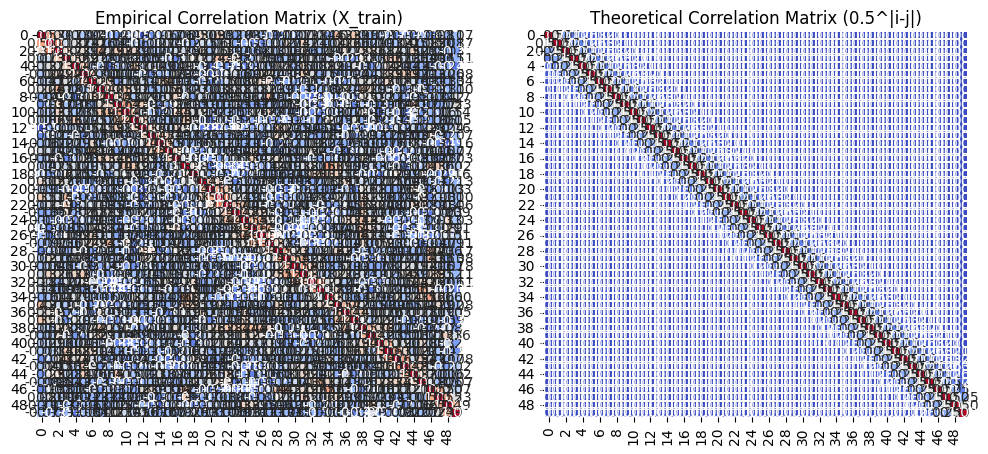

In [19]:
# Calculate empirical correlation matrix
corr_matrix = np.corrcoef(X_train, rowvar=False)

# Calculate theoretical correlation matrix
p = X_train.shape[1]
theoretical_corr_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[0], cbar=False)
axes[0].set_title("Empirical Correlation Matrix (X_train)")
sns.heatmap(theoretical_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1], cbar=False)
axes[1].set_title("Theoretical Correlation Matrix (0.5^|i-j|)")

plt.show()

In [20]:
# Simple linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(lr.intercept_)
print(lr.coef_)

2.5029745279260864
[ 0.4321654  -0.087046   -0.48300763  0.65061104 -1.74963726 -0.07963495
 -0.18193116  0.38689941 -0.243989   -1.14348862 -0.58228537 -0.17530882
 -0.80473224  1.22841055 -0.76591314  1.16744601  2.06023541  0.22054193
 -0.19374168  0.28237663  2.2442882   0.50732734  0.37774582  0.24591478
  0.44586016 -0.64632019 -0.38868977  0.39751107 -0.58291851  0.03595236
  0.8122173  -0.88583747  1.11173988 -1.77441157  0.73679289 -0.71266039
 -0.42065315 -1.14947126 -0.05627241  0.92880912  1.4154026  -0.50975242
  0.2241559   0.43855519 -0.2991358  -1.58057933  1.11595579 -0.09357688
 -0.10321978 -0.95319343]


##### Frequentist Lasso

In [21]:
# Define parameter grid for alpha (regularization parameter)
param_grid = {'alpha': [0.01, 0.1, 0.3, 0.5, 0.9, 1, 3, 5, 10]}

# Perform Grid Search with Cross-Validation
grid = GridSearchCV(Lasso(fit_intercept=True), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Retrieve the best alpha and corresponding model
best_alpha = grid.best_params_['alpha']
best_model = grid.best_estimator_

# Predictions using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Evaluation
mse_train_freq = mean_squared_error(y_train, y_pred_train)
mse_test_freq = mean_squared_error(y_test, y_pred_test)

# Print the results
print("Frequentist Lasso Results with Hyperparameter Tuning:")
print(f"Best alpha: {best_alpha}")
print(f"Train MSE: {mse_train_freq:.3f}")
print(f"Test MSE: {mse_test_freq:.3f}")
print("Best Coefficients:", best_model.coef_)

c:\Users\marie\OneDrive\Documents\cours\ensae\3A\stats bayésiennes\.venvSB\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.509e-01, tolerance: 7.587e-02
  model = cd_fast.enet_coordinate_descent(


Frequentist Lasso Results with Hyperparameter Tuning:
Best alpha: 1
Train MSE: 14.668
Test MSE: 39.156
Best Coefficients: [-0.          0.         -0.          0.         -0.         -0.
  0.         -0.          0.         -0.02745684 -0.         -0.68449825
 -0.          0.          0.          0.98844175  0.          0.
 -0.53511719  0.          2.17051529  0.          0.37161541  0.
  0.         -0.         -0.          0.         -0.         -0.
  0.         -0.          0.         -0.          0.         -0.
 -0.         -0.02357398  0.          0.66623347  0.21895675 -0.
 -0.         -0.          0.         -0.          0.          0.
 -0.         -0.        ]


##### Bayesian Lasso

- With mean estimators :

In [ ]:
a = 1  # Shape parameter for Gamma prior
b = 0.1  # Scale parameter for Gamma prior

with pm.Model() as bayesian_lasso:
    # Prior for regularization parameter lambda
    lambda_param = pm.Gamma("lambda", alpha=a, beta=b)
    
    # Priors for the regression coefficients
    tau = pm.Exponential("tau", lambda_param, shape=X_train.shape[1])
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood (data model)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X_train, beta)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

    # Inference
    trace = pm.sample(1000, tune=1000, target_accept=0.9,  return_inferencedata=True, progressbar=True)

# Posterior summaries
pm.plot_posterior(trace, var_names=["beta", "intercept"], hdi_prob=0.95)

summary = az.summary(trace, var_names=["beta", "intercept"], hdi_prob=0.95)
display(summary)

# Retrieve the posterior means for the coefficients
beta_post_mean = trace.posterior["beta"].mean(axis=(0,1))
intercept_post_mean = trace.posterior["intercept"].mean()
print("Bayesian Lasso Results:")
print("Posterior Means for Coefficients:", beta_post_mean)
print("Posterior Mean for Intercept:", intercept_post_mean)

In [ ]:
# Posterior Predictions
with bayesian_lasso:
    posterior_predictive = pm.sample_posterior_predictive(trace)

posterior_predictive_data = posterior_predictive['posterior_predictive']
# print("Available keys inside posterior_predictive:", list(posterior_predictive_data.keys()))

# Extract the predictions
y_pred_samples = posterior_predictive_data['y'].values
# Compute posterior mean of y for each observation (across all chains and draws)
y_pred_mean = y_pred_samples.mean(axis=(0, 1))  # Averaging over chains (axis=0) and draws (axis=1)
# Extract observed y values
y_obs = posterior_predictive['observed_data']['y'].values

# Compute the Mean Squared Error (MSE)
mse = mean_squared_error(y_obs, y_pred_mean)
print(f"MSE: {mse:.3f}")

In [ ]:
# Generate predictions for the test dataset
with bayesian_lasso:
    # Extract posterior samples of beta and intercept
    beta_samples = trace.posterior["beta"].stack(samples=("chain", "draw")).values
    intercept_samples = trace.posterior["intercept"].stack(samples=("chain", "draw")).values

# Compute predicted means for X_test
y_pred_test_samples = np.dot(X_test, beta_samples) + intercept_samples
# Compute posterior predictive mean (average over all samples)
y_pred_test_mean = y_pred_test_samples.mean(axis=1)  # Averaging over all posterior samples

# Compute the Mean Squared Error (MSE) for the test set
mse_test = mean_squared_error(y_test, y_pred_test_mean)
print(f"MSE on Test Set: {mse_test:.3f}")


- With mode estimators :

In [22]:
a = 1  # Shape parameter for Gamma prior
b = 0.1  # Scale parameter for Gamma prior

with pm.Model() as bayesian_lasso:
    # Prior for regularization parameter lambda
    lambda_param = pm.Gamma("lambda", alpha=a, beta=b)
    
    # Priors for the regression coefficients
    tau = pm.Exponential("tau", lambda_param, shape=X_train.shape[1])
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood (data model)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X_train, beta)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

    # Find the posterior mode
    map_estimate = pm.find_MAP()

# Extract posterior mode for beta and intercept
beta_post_mode = map_estimate["beta"]
intercept_post_mode = map_estimate["intercept"]

# Display results
print("Bayesian Lasso Results:")
print("Posterior Mode for Coefficients:", beta_post_mode)
print("Posterior Mode for Intercept:", intercept_post_mode)

Output()

c:\Users\marie\OneDrive\Documents\cours\ensae\3A\stats 
bayésiennes\.venvSB\Lib\site-packages\pytensor\scalar\basic.py:3185: RuntimeWarning: overflow encountered in scalar
multiply
  return x * x

c:\Users\marie\OneDrive\Documents\cours\ensae\3A\stats 
bayésiennes\.venvSB\Lib\site-packages\pytensor\scalar\basic.py:3079: RuntimeWarning: overflow encountered in exp
  return np.exp(x)

Bayesian Lasso Results:
Posterior Mode for Coefficients: [-1.14459857e-10 -4.94826704e-11 -5.75951950e-10  3.60330378e-10
  4.49428105e-09  5.17102602e-10 -5.91961135e-10  5.94760046e-10
  5.17754975e-11 -2.65836887e-09  2.41303005e-09 -2.32883226e-09
  2.14888131e-10  1.92595956e-10 -1.19216036e-12  7.66297412e-10
 -2.17446324e-10 -8.08832292e-11  1.91409645e-10 -1.57247636e-10
  2.83939310e-09  2.11045425e-10  2.45555250e-10 -6.77031857e-10
  3.95857929e-10 -6.04187735e-11 -1.02503271e-09 -2.31133160e-10
  2.60818778e-10 -1.17050477e-11 -3.16152417e-11  3.16634760e-11
 -3.06999792e-11  1.00474203e-09  1.57901645e-10  4.13659879e-10
  1.56591243e-10 -2.17814056e-10  2.25583574e-10 -6.69597681e-10
 -1.21354573e-10  7.20630478e-11  2.77151768e-10  6.36273260e-10
  1.47813134e-10  3.10413156e-12  4.45591956e-10  7.93680071e-11
  9.26262438e-12 -5.99413314e-10]
Posterior Mode for Intercept: 32.84714306281069


Comparisons

In [ ]:
# True coefficients
print("True beta: ", beta3)

# Frequentist Lasso Coefficients
print('\n----- FREQUENTIST LASSO -----')
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5).fit(X_train, y_train)
print("\nFrequentist Lasso Coefficients:", lasso.coef_)
print(f"MSE on Train Set: {mse_train_freq:.3f}")
print(f"MSE on Test Set: {mse_test_freq:.3f}")

# Bayesian Lasso Posterior Means
print('\n----- BAYESIAN LASSO -----')
beta_post_mean = trace.posterior["beta"].mean(axis=(0, 1))
print("\nBayesian Lasso Posterior Means:", beta_post_mean)
print(f"MSE on Train Set: {mse:.3f}")
print(f"MSE on Test Set: {mse_test:.3f}")